## Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License")

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Image segmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

This tutorial primarily uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

* Class 1: Pixel belonging to the pet.
* Class 2: Pixel bordering the pet.
* Class 3: None of the above/a surrounding pixel.

The network can also be trained on the [Pascal VOC2012 dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/).

## Installations and Imports

As usual, we would import all the relevant python modules that we would use to implement, train and test our neural network.

We first import os and make a variable to keep note of our working environment, which will allow us to use if-else cases such that the same code can be run in tensorflow as well as the local device.

In [1]:
import os
import sys

if os.getenv("COLAB_RELEASE_TAG"):
    inColab = True
    inKaggle = not inColab
elif os.getenv("KAGGLE_URL_BASE"):
    inKaggle = True
    inColab = not inKaggle
else: # if you're using a local machine
    inColab = False
    inKaggle = False

host_name_str = os.popen('hostname').read().encode('utf-8')
print(host_name_str)

b'edc66422e5c2\n'


### Only while using Kaggle
If using Kaggle, run the following module in addition to the other modules that follow, if not then it is to be ignored (since some of the libraries are not updated on the environment it uses to run the code):

Once finished, restart the kernel so that the installations show up, especially in the case of tensorflow. 

P.S. Comment out the segmentation models imports and uses since they weren't particularly helpful in our pursuits.

In [2]:
%%capture
if inKaggle:
    !pip install tensorflow==2.9.0
    !pip install --upgrade tensorflow-addons
#     !pip install -U segmentation-models
    !pip install focal-loss
    !add-apt-repository -y ppa:deadsnakes/ppa
    !apt install -y python3
    !pip install protobuf==3.19.*
    !yes | apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

    !pip install --upgrade pip
    !pip install --upgrade "jax[cuda]"
    # !pip install --upgrade tensorflow_hub

elif inColab:
    %env SM_FRAMEWORK=tf.keras
    !pip install tensorflow-addons
#     !pip install segmentation-models
    !pip install focal-loss
    # !pip install --upgrade tensorflow_hub

### Importing the necessary libraries
Keras Modules are imported from tensorflow furthermore to reduce the length of the code while using the relevant predefined functions and therefore improve the readability of the code.

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
# import tensorflow_hub as hub
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cv2
import functools
# import segmentation_models as sm
from focal_loss import SparseCategoricalFocalLoss

from tensorflow import keras
from keras import layers
from keras import optimizers
from keras import models
from keras import backend

## Loading and Splitting the Dataset
The dataset is perhaps the most important pre-requisite to a neural network, so we pre process it such that it is easier to use with the neural network that we are going to use, adding functions of relevance for visualization during training and testing, as well as splitting it appropriately between training and testing cases.

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

We have the option of using the tfds dataset, which is fairly straightforward if the dataset that you're working with is available on it. In addition, we can also load the dataset using TensorFlow functions exclusively, as implemented below.

The dataset already contains the required training and test splits, so continue to use the same splits, which is implemented in the latter part of the code.

In [4]:
def load_and_split_dataset(BATCH_SIZE, BUFFER_SIZE, load_from_tfds, img_dir, 
                           mask_dir, train_txt_path, val_txt_path, input_shape):
    """
    BATCH_SIZE: (Integer)
        As obvious, the batch size is to be specified.
        
    BUFFER_SIZE: (Integer) 
        As obvious, the buffer size is to be specified.
        
    load_from_tfds: [Boolean] 
        A variable to check if the dataset is 
        loaded using tfds or from a custom pipeline.
        
    img_dir: (String) 
        The path to the directory that contains training and validation images.
        
    mask_dir: (String) 
        The path to the directory that contains the training and 
        validation labelled masks.
        
    train_path_txt: (String) 
        The path to the directory that contains the list of images
        belonging to the training datasets.
        
    val_path_txt: (String) 
        The path to the directory that contains the list of images
        belonging to the validation datasets.
        
    input_shape: (Tuple) 
        The 2-dimensional shape of the input images that will make the dataset. 
    """
    
    if load_from_tfds:
        dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
        train_images = dataset['train']\
                       .map(functools.partial(load_image,
                                              input_shape=input_shape),
                            num_parallel_calls=tf.data.AUTOTUNE)
        validation_images = dataset['test']\
                            .map(functools.partial(load_image,
                                                   input_shape=input_shape),
                                 num_parallel_calls=tf.data.AUTOTUNE)
        TRAIN_LENGTH = info.splits['train'].num_examples
        VAL_LENGTH = info.splits['test'].num_examples
    else:
        train_data =[]
        train_mask =[]
        with open(train_txt_path) as f:
            for line in f:
                train_data.append(os.path.join(img_dir, 
                                               line.split()[0]+'.jpg'))
                train_mask.append(os.path.join(mask_dir, 
                                               line.split()[0]+'.png'))
        validation_data =[]
        validation_mask =[]
        with open(val_txt_path) as f:
            for line in f:
                validation_data.append(os.path.join(img_dir, 
                                                    line.split()[0]+'.jpg'))
                validation_mask.append(os.path.join(mask_dir,
                                                    line.split()[0]+'.png'))
        train_images = tf.data.Dataset.from_tensor_slices((train_data,
                                                           train_mask))
        validation_images = tf.data.Dataset.from_tensor_slices((validation_data, 
                                                                validation_mask))
        train_images = train_images.map(functools.partial(load_image_alter, 
                                                          input_shape=input_shape),
                                        num_parallel_calls=tf.data.AUTOTUNE)
        validation_images = validation_images.map(functools.partial(load_image_alter, 
                                                                    input_shape=input_shape),
                                                  num_parallel_calls=tf.data.AUTOTUNE)
        TRAIN_LENGTH = len(train_data)
        VAL_LENGTH = len(validation_data)
    train_batches = (train_images
                    # .cache()
                    .shuffle(BUFFER_SIZE)
                    .batch(BATCH_SIZE)
                    .repeat()
                    .map(Augment())
                    .prefetch(buffer_size=tf.data.AUTOTUNE))
    validation_batches = validation_images.batch(BATCH_SIZE)
    return train_batches, validation_batches, TRAIN_LENGTH, VAL_LENGTH

## Image Processing Utility Functions
These are the functions that assist in loading the images into the dataset so that they can be processed as tensors all the same (i.e. all of them have same dimensions and normalized pixel values in our case), as well as adding to the dataset by augmenting them.


* `normalize()` function normalizes the image by converting all of the pixel values between 0 and 1 for the input image, and offsets all of the labelled mask pixel values by 1, so that instead of them being [1, 2, 3] for our case, they are [0, 1, 2].
*  `load_image()` function - Reads the input image and normalizes it.
* `load_image_alter()` function - Same as `load_image()`, except it is used when loading the dataset from a directory, directly (i.e. without using tfds).
* The class `Augment()` performs a simple augmentation by randomly-flipping an image horizontally. (subclass to the `tf.keras.layer.Layer`)
The image and the mask use the same seed so that whenever random flipping occurs, it is for both of them.

In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 127.5 - 1
    input_mask -= 1
    input_mask = tf.cast(input_mask, tf.float32)
    return input_image, input_mask


def load_image(datapoint, input_shape):
    input_image = tf.image.resize(datapoint['image'], input_shape)
    input_mask = tf.image.resize(datapoint['segmentation_mask'],
                                 input_shape,
                                 # tuple(int(elem/2) for elem in input_shape),
                                 method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask


# This function is used only when the dataset isn't loaded using tfds.
def load_image_alter(image_path, mask_path, input_shape):
    data_image = tf.io.read_file(image_path)
    data_image = tf.io.decode_jpeg(data_image, channels=3)
    data_image = tf.image.resize(data_image, input_shape)

    mask_image = tf.io.read_file(mask_path)
    mask_image = tf.io.decode_png(mask_image, channels=1)
    mask_image = tf.image.resize(mask_image, input_shape, # tuple(int(elem/2) for elem in input_shape),
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    data_image, mask_image = normalize(data_image, mask_image)
    return data_image, mask_image


class Augment(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment = tf.keras.layers.RandomFlip(mode="horizontal", seed=20)

    def call(self, inputs, labels):
        # The label data is converted to uint8 so that we can concatenate it with the inputs with datatype float32.
        # labels = tf.image.convert_image_dtype(labels, dtype=tf.float32)
        output = self.augment(layers.concatenate([inputs, labels], axis=-1))
        # This is because the data that I am using has 3 channels for inputs and 1 channel for labels.
        inputs = output[:,:,:,0:3]
        labels = output[:,:,:,3:]
        # Labels converted back to uint8
        # labels = tf.image.convert_image_dtype(labels, dtype=tf.uint8)
        return inputs, labels

## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler).

*To learn robust features and reduce the number of trainable parameters, the Tensorflow documentation uses a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, it uses an upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)*

For this particular case though, **we would be using a standard U-net that is implemented in `DenseUNet`, and a more sophisticated U-net that is implemented in `pixelUNet`**, in a comparative manner. The former is as described, a standard U-net structure that uses `pixelDCL()` and `iPixelDCL()` in a way that is discussed in [Pixel Deconvolutional Networks](https://arxiv.org/pdf/1705.06820.pdf).

The following classes simplify the implementation of 
* `BatchActivate()`: Batch Normalization followed by Relu Activation.
* `adsConv2D()`: Atrous Depthwise Convolution - A two step convolution, that reduces the number of trainable parameters.
    * `Depthwise`: With a given kernel size, and the number of filters remains the same.
    * `Pointwise`: With a (1, 1) kernel, and the number of filters are the number of filters desired by the output.
* `atrousSPP()`: Atrous Spatial Pyramidal Pooling - Convolutions with different kernel sizes provided as inputs which are finally concatenated.
* `DenseLayer()`: Dense Layer - A sequence of batchnorm -> relu activation -> convolution -> dropout, adapted from [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/pdf/1611.09326v3.pdf), which has been subsequently modified after adaptation from [Densely connected convolutional networks](https://arxiv.org/pdf/1608.06993.pdf).

In [6]:
class BatchActivate(keras.layers.Layer):
    """
    Batchnormalization of the input followed by a ReLU activation.
    """
    def __init__(self, activation='relu'):
        super().__init__()
        self.activation =  activation
        
    def build(self, input_shape):
        if inKaggle:
            self.batchnorm = layers.BatchNormalization()
        elif inColab:   
            self.batchnorm = layers.BatchNormalization(synchronized=True)
        self.activate = layers.Activation(self.activation)
        super().build(input_shape)
        
    def call(self, inputs):
        return self.activate(self.batchnorm(inputs))
    
    def get_config(self):
        config = super().get_config()
        config.update({
                        "activation": self.activation
                     })
        return config

    
class adsConv2D(keras.layers.Layer):
    """
    Atrous Depthwise Separable 2D Convolution: https://arxiv.org/pdf/1802.02611.pdf
    """
    def __init__(self, filters, kernel_depthwise, padding='valid',
                 strides=1, activation=None, dilation_rate=1, 
                 kernel_initializer='he_uniform'):
        super().__init__()
        self.filters = filters
        self.kernel_depthwise = kernel_depthwise
        self.padding = padding
        self.strides = strides
        self.activation = activation
        self.dilation_rate = dilation_rate
        self.kernel_initializer = kernel_initializer
        
    def build(self, input_shape):
        self.pointwise = layers.Conv2D(filters=self.filters, 
                                       kernel_size=(1, 1), 
                                       activation=self.activation, 
                                       kernel_initializer=self.kernel_initializer)
        self.depthwise = layers.DepthwiseConv2D(kernel_size=self.kernel_depthwise, 
                                                padding=self.padding,
                                                activation=self.activation,
                                                strides=self.strides,
                                                dilation_rate=self.dilation_rate, 
                                                kernel_initializer=self.kernel_initializer)
        super().build(input_shape)
        
    def call(self, inputs):
        return self.pointwise(self.depthwise(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({
                        "filters": self.filters,
                        "kernel_depthwise": self.kernel_depthwise,
                        "padding": self.padding,
                        "strides": self.strides,
                        "activation": self.activation,
                        "dilation_rate": self.dilation_rate
                     })
        return config

    
class atrousSPP(keras.layers.Layer):
    """
    Atrous Spatial Pyramidal Pooling, also implemented in Deeplabv3+:
    https://arxiv.org/pdf/1802.02611.pdf

    kernel_size: (Tuple of Integers) The kernel size used for the parallel convolutions
                  before concatenation.
    in_filters: (Integer) The number of filters in the input (due to this particular implementation).
    channel_axis: (Integer) The channel axis for all of the input tensors.
    num_outputs: (Integer) The number of channels desired in the output of this layer.
    conv_option: (String) To choose the convolution type, either "conv2d" or "adsconv2d".
    pyramid_dilations: (List of Integers) The dilation values for the parallel convolutions.
                      (for both the dimensions of a 2D image)
    """
    def __init__(self, kernel_size, in_filters, channel_axis, 
                 num_outputs, conv_option, pyramid_layers):
        super().__init__()
        self.kernel_size = kernel_size
        self.in_filters = in_filters
        self.channel_axis = channel_axis
        self.num_outputs = num_outputs
        self.conv_option = conv_option
        self.pyramid_layers = pyramid_layers
        
    def build(self, input_shape):
        self.conv_list = []
        for dilation in self.pyramid_layers:
            self.conv_list.append(adsConv2D(self.in_filters, self.kernel_size, 
                                            padding='same', dilation_rate=dilation))
        self.convf = conv2_op(self.conv_option)(self.num_outputs, (1, 1), 
                                                padding='same')  
        super().build(input_shape)
        
    def call(self, inputs):
        return self.convf(layers.concatenate([conv(inputs) for conv in self.conv_list],
                          axis=self.channel_axis))

    def get_config(self):
        config = super().get_config()
        config.update({
                        "kernel_size": self.kernel_size,
                        "in_filters": self.in_filters,
                        "channel_axis": self.channel_axis,
                        "num_outputs": self.num_outputs,
                        "conv_option": self.conv_option,
                        "pyramid_layers": self.pyramid_layers
                     })
        return config
    

class DenseLayer(keras.layers.Layer):
    """
    This class implements the Dense layer comprised of the following: 
    Batchnormalization -> Relu activation -> Convolution (depthwise or built-in) -> Dropout.
    
    This layer is discussed in great detail in the following paper:
    https://arxiv.org/pdf/1611.09326.pdf
    """
    def __init__(self, growth_rate, kernel_dense, dropout, 
                 conv_option):
        """
        *****************
        *** Arguments ***
        *****************
        kernel_dense: (Tuple) the kernel size used for convolutions and deconvolutions.
        growth_rate: (Integer) The number of feature maps for each layer of the denseblock.
        dropout: (Integer) The dropout value for the denseblock.
        conv_option: (String) Sets the convolution type. Either 'conv2d' or 'adsconv2d'.
        """
        super().__init__()
        self.growth_rate = growth_rate
        self.kernel_dense = kernel_dense
        self.dropout = dropout
        self.conv_option = conv_option
        
    def build(self, input_shape):
        self.dropout = layers.Dropout(self.dropout)
        self.conv = conv2_op(self.conv_option)(self.growth_rate,
                                               self.kernel_dense,
                                               padding='same')
        self.batchact = BatchActivate(activation=tf.keras.layers.PReLU())
        super().build(input_shape)
        
    def call(self, inputs):
        """
        inputs: Input tensors.
        """
        return self.dropout(self.conv(self.batchact(inputs)))
    
    def get_config(self):
        config = super().get_config()
        config.update({
                    "growth_rate": self.growth_rate,
                    "kernel_dense": self.kernel_dense,
                    "dropout": self.dropout,
                    "conv_option": self.conv_option
        })
        return config
    

class dilate_tensor(keras.layers.Layer):
    def __init__(self, axis, row_shift, column_shift, 
                 upsample_factor):
        super().__init__()
        self.axis = axis
        self.row_shift = row_shift
        self.column_shift = column_shift
        self.upsample_factor = upsample_factor
        
    def call(self, inputs):
        row_shifts = [item for item in range(self.upsample_factor)]
        row_shifts.remove(self.row_shift)
        rows = tf.unstack(inputs, axis=self.axis[0])
        row_zeros = tf.zeros_like(rows[0], dtype=tf.float32)

        for step, rshift in enumerate(row_shifts):
            for index in range(len(rows), 0, -(step+1)):
                rows.insert(index-rshift, row_zeros)
        inputs = tf.stack(rows, axis=self.axis[0])

        column_shifts = [item for item in range(self.upsample_factor)]
        column_shifts.remove(self.column_shift)
        columns = tf.unstack(inputs, axis=self.axis[1])
        columns_zeros = tf.zeros_like(columns[0], dtype=tf.float32)

        for step, cshift in enumerate(column_shifts):
            for index in range(len(columns), 0, -(step+1)):
                columns.insert(index-cshift, columns_zeros)
        inputs = tf.stack(columns, axis=self.axis[1])
        return inputs
    
    def get_config(self):
        config = super().get_config()
        config.update({
                        "axis": self.axis,
                        "row_shift": self.row_shift,
                        "column_shift": self.column_shift,
                        "upsample_factor": self.upsample_factor,
                     })
        return config

The following cell implements simpler functions for convolutions and downsampling that will be used in the UNet.
* `batchnorm()`: Batchnormalization for the entire code, had to add it due to the changes in the syntax of *'synchronized=True'* in Tensorflow 2.12.
* `conv2_op()`: General Convolution - Chooses from `adsConv2D` and `Conv2D` and provides with a conv object as an output.
* `downsample2_op()`: General Pooling - Chooses from `MaxPooling` and `conv2_op` with stride 2 and provides with a pool object as output.

In [7]:
def BatchNorm(inputs):
    """
    Configures the Batchnormalization for the entire code. In case you have Tensorflow 2.12 or above installed on your machine,
    change the if else conditions to meet your requirements.
    """
    if inColab:
        outputs = layers.BatchNormalization(synchronized=True)(inputs)
    else:
        outputs = layers.BatchNormalization()(inputs)
    return outputs
  

def conv2_op(conv_option):
    if conv_option == 'conv2d':
        def conv_in(filters, kernel_size, 
                    strides=1, padding='valid',
                    dilation_rate=1, activation=None, 
                    kernel_initializer='he_uniform'):
            return tf.keras.layers.Conv2D(filters, kernel_size, 
                                          strides=strides, 
                                          padding=padding,
                                          dilation_rate=dilation_rate, 
                                          activation=activation, 
                                          kernel_initializer=kernel_initializer)
    elif conv_option == 'sepconv2d':
        # The built-in layer that I wasn't aware of.
        def conv_in(filters, kernel_size, 
                    strides=1, padding='valid',
                    dilation_rate=1, activation=None,
                    kernel_initializer='he_uniform'):
            return tf.keras.layers.SeparableConv2D(filters, kernel_size, 
                                                   strides=strides, 
                                                   padding=padding,
                                                   dilation_rate=dilation_rate, 
                                                   activation=activation, 
                                                   kernel_initializer=kernel_initializer)
    elif conv_option == 'adsconv2d':
        # The layer that I made, because I didn't know there was a built-in layer to do the same thing.
        def conv_in(filters, kernel_size, 
                    strides=1, padding='valid',
                    dilation_rate=1, activation=None,
                    kernel_initializer='he_uniform'):
            return adsConv2D(filters, kernel_size, 
                             strides=strides, 
                             padding=padding,
                             dilation_rate=dilation_rate,
                             activation=activation, 
                             kernel_initializer=kernel_initializer)

#     elif conv_option == 'ipixel' or 'pixel':
#         def conv_in(out_num, kernel_size, upsample_rate=2, strides=1,
#                     padding='same', dilation_rate=1, d_format='NHWC'):
#             return customCL(out_num, kernel_size, upsample_rate, strides,
#                             padding, dilation_rate, d_format)
    return conv_in


def downsample2_op(conv_option, pool_option):
    if pool_option == 'pool':
        def downsample_in(num_outputs):
            return layers.MaxPooling2D((2, 2))
    elif pool_option == 'conv':
        def downsample_in(num_outputs):
            return conv2_op(conv_option)(num_outputs, (2, 2), 
                                         padding='same', strides=2)
    return downsample_in

### PixelDCL and iPixelDCL
The following is the implementation of a UNet that either uses regular deconvolution, pixelDCL or ipixelDCL as discussed in [Pixel Deconvolutional Networks](https://arxiv.org/pdf/1705.06820.pdf). These implementations do not require the structure of the UNet to be changed, and therefore can be instantiated mutually exclusively using an if else statement within the up convolution part of the UNet.

The dilate tensor function is to be used in the `pixel_dcl` and `ipixel_dcl`  functions for the final step of doubling the size of the input tensor using the implementation trick discussed in the mentioned paper, which reduces the training and testing time.

The down, bottom and the up blocks are the building blocks of the UNet that is implemented in the `pixelUNet()`.


*Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.*


Before that however, we need to define our custom transposed convolution operations (which are often mistakenly called deconvolutions, which is a different operation that is supposed to be the mathematical inverse of convolution, which is why the name DCL is used for all of the code in this notebook). The following block of code defines these two pixelDCLs.

`pixelDCL` is the implementation of what was discussed in the source material (the paper linked in the description above).

`pixelDCL2` is a modification of the pixelDCL scheme, where each of the convolutions is independent of each other and directly linked to the input. These intermediate outputs are shuffled and combined to produce a larger feature map, similar to what the original paper did, except for the fact that all of these convolutions can be run parallely since they are independent of each other, whereas in the original paper all of the convolutions had to be sequential.

In [8]:
class customDCL:
    """
    Upsamples the input by 'upsample_rate' using the methods discussed in:
    https://arxiv.org/pdf/1705.06820.pdf
    """
    def __init__(self, dcl_type, out_num, kernel_size, 
                 upsample_rate, conv_option, d_format='NHWC'):
        """
        *****************
        *** Arguments ***
        *****************

        inputs: (4D tensor)
            Input tensor, with the dimensions.
            (batch_size, input_height, input_width, out_num)

        out_num: (integer)
            Output channel number.

        kernel_size: (2-tuple of integers)
            Convolutional kernel size.
        """
        self.dcl_type = dcl_type
        self.out_num = out_num
        self.kernel_size = kernel_size
        self.upsample_rate = upsample_rate
        self.conv_option = conv_option
        self.d_format = d_format
        self.image_dim = 2
        
    def DCL(self, inputs):
        axis =  (self.d_format.index('H'), self.d_format.index('W'))
        channel_axis = self.d_format.index('C')
        loop_inputs = inputs
        dilated_outputs = []
        for index in range(self.upsample_rate**self.image_dim):
            column_index = index%self.upsample_rate
            row_index = int(index/self.upsample_rate)%self.upsample_rate
            loop_inputs = BatchActivate(activation='relu')(loop_inputs)
            conv = conv2_op(self.conv_option)(self.out_num, 
                                         self.kernel_size, 
                                         padding='same')(loop_inputs)
            dilated_outputs.append(dilate_tensor(axis,
                                                 row_index, 
                                                 column_index,
                                                 self.upsample_rate)(conv))
            loop_inputs = conv if index==0 and self.dcl_type == 'pixel' \
                          else layers.concatenate([loop_inputs, conv],
                                                  axis=channel_axis)
        outputs = tf.add_n(dilated_outputs)
        return outputs
    
    def __call__(self, inputs):
        """
        ***************
        *** Returns ***
        ***************
        
        outputs: (4D tensor)
            Output tensor, with the dimensions.
            (batch_size, upsample_rate*input_height, upsample_rate*input_width, out_num)
        """
        return self.DCL(inputs)

class customDCL2:
    """
    Upsamples the input by 'upsample_rate', similar to `customDCL`, 
    except in this case all of the convolutions are independent of each other, unlike customDCL where 
    all of the operations are sequential.
    """
    def __init__(self, dcl_type, out_num, kernel_size, 
                 upsample_rate, conv_option, d_format='NHWC'):
        """
        *****************
        *** Arguments ***
        *****************

        inputs: (4D tensor)
            Input tensor, with the dimensions.
            (batch_size, input_height, input_width, out_num)

        out_num: (integer)
            Output channel number.

        kernel_size: (2-tuple of integers)
            Convolutional kernel size.
        """
        self.dcl_type = dcl_type
        self.out_num = out_num
        self.kernel_size = kernel_size
        self.upsample_rate = upsample_rate
        self.conv_option = conv_option
        self.d_format = d_format
        self.image_dim = 2
        
    def DCL(self, inputs):
        axis =  (self.d_format.index('H'), self.d_format.index('W'))
        channel_axis = self.d_format.index('C')
        loop_inputs = inputs
        dilated_outputs = []
        for index in range(self.upsample_rate**self.image_dim):
            column_index = index%self.upsample_rate
            row_index = int(index/self.upsample_rate)%self.upsample_rate
            loop_inputs = BatchActivate(activation='relu')(loop_inputs)
            conv = conv2_op(self.conv_option)(self.out_num, 
                                         self.kernel_size, 
                                         padding='same')(loop_inputs)
            dilated_outputs.append(dilate_tensor(axis,
                                                 row_index, 
                                                 column_index,
                                                 self.upsample_rate)(conv))
        outputs = tf.add_n(dilated_outputs)
        return outputs
    
    def __call__(self, inputs):
        """
        ***************
        *** Returns ***
        ***************
        
        outputs: (4D tensor)
            Output tensor, with the dimensions.
            (batch_size, upsample_rate*input_height, upsample_rate*input_width, out_num)
        """
        return self.DCL(inputs)

We now define the block that defines the UNet model. It is comprised of up and down blocks, and process the input with a convolutional layer so that the number of filters in the input is increased before it is processed in the U-net.

The `down block` consists of a `DenseBlock` followed by a `TransitionDown` block, which processes the input and adds filters to it, whilst reducing its dimensions (in our case by 2). The final down block is the bottleneck layer in our implementation, and for that reason it doesn't contain a downsampling layer but instead a `atrousSPP` layer, which enforces the relations between the neighbouring pixels.

The up block consists of an `upsample` layer followed by a concatenation from the down block at the same level, the result of which is passed to a `DenseBlock`, which for this case doesn't concatenate its inputs with its outputs, as it did for the down block. The final up block is the final layer of the net, and it concludes the network with a softmax activation function that specifies the number of classes for classifying the output.

**Control models**

We use two control models for this system
1. The Standard U-Net, from Ronneberger et al.
2. Deeplab Xception, the model that has performed the best in segmentation of Pascal VOC2012 dataset.

These models, along with the pixelDenseUNet, is contained within the same class, named the `modelClass`. These models are to compare the results with the pixeldenseUNet.

In [9]:
class modelClass:
    def __init__(self, input_shape, network_depth, dcl_type, 
                 out_classnum, filtersize, dense_layers, growth_rate, 
                 dropout, conv_option, pool_option, pyramid_layers,
                 d_format='NHWC'):
        """       
        *****************
        *** Arguments ***
        *****************

        input_shape: (Tuple of integers) 
            Three dimensions representing the input shape in the form:
            (input_height, input_width, input_channels)

        network_depth: (Integer)
            Depth of the Unet.

        cl_type: (String) 
            'builtin' for normal convolution, 'ipixel' for ipixel convolution.

        dcl_type: (String) 
            'builtin' for normal deconvolution, 'pixel' for pixel deconvolution,
            'ipixel' ipixel deconvolution.

        out_classnum: (Integer) 
            The number of output classes.

        filtersize: (Integer) 
            The number of filters/channels for the first layer of the Unet.

       dense_layers: (List of integers) 
           The number of dense layers in the denseblock in the Unet
           at the depth corresponding to the list index.

        growth_rate: (Integer) 
            The number of kernels/filters in each layer of
            the denseblock.

        dropout: (Integer) 
            The dropout value for the denseblock.

        conv_option: (String) 
            Sets the convolution type. Either 'conv2d' or 'adsconv2d'.

        pool_option: (String) 
            Sets the pooling option. Either 'builtin' or 'conv'.

        pyramid_layers: (List of integers) 
            The dilation values for atrous convolution that will be
            used in atrousSPP.

        d_format: (String) 
            The data format of the input tensors - NHWC or NHCW.
        """
        self.input_shape = input_shape
        self.network_depth = network_depth
        self.dcl_type = dcl_type
        self.out_classnum = out_classnum
        self.filtersize = filtersize
        self.dense_layers = dense_layers
        self.growth_rate = growth_rate
        self.dropout = dropout
        self.conv_option = conv_option
        self.pool_option = pool_option
        self.pyramid_layers = pyramid_layers
        self.d_format = d_format
    
    def DenseBlock(self, inputs, dense_layers, growth_rate,
                   kernel_dense, dropout, channel_axis, conv_option):
        layer_input = inputs
        dense = []
        for dense_layer in range(dense_layers):
            denseouts = DenseLayer(growth_rate, kernel_dense, 
                                   dropout, conv_option)(layer_input)
            dense.append(denseouts)
            layer_input = layers.concatenate([layer_input, denseouts],
                                             axis=channel_axis)
        dense_final = layers.concatenate([dense_item for dense_item in dense],
                                         axis=channel_axis)
        dense_concat = layers.concatenate([inputs, dense_final],
                                          axis=channel_axis)
        return dense_final, dense_concat
    
    def ResnetBlock(self, inputs, repeats, filters,
                    kernel_dense, dropout, channel_axis, conv_option):
        layer_input = inputs
        for dense_layer in range(repeats):
            denseout1 = DenseLayer(filters, kernel_dense, 
                                   dropout, conv_option)(layer_input)
            denseout2 = DenseLayer(filters, kernel_dense, 
                                   dropout, conv_option)(denseout1)   
            layer_input = layers.Add()([layer_input, denseout2])
        return layer_input

    def TransitionDown(self, inputs, num_outputs, dropout,
                       conv_option, pool_option):
        conv = DenseLayer(num_outputs, (1, 1), dropout, conv_option)(inputs)
        conv = downsample2_op(conv_option, pool_option)(num_outputs)(conv)
        return conv

    def TransitionUp(self, inputs, dcl_type, num_outputs, conv_option,
                     kernel_size_u, upsample_rate):
        if dcl_type == 'builtin':
            convt = layers.Conv2DTranspose(num_outputs, upsample_rate, 
                                           strides=upsample_rate, padding='same',
                                           kernel_initializer='he_uniform')(inputs)
#             convt = layers.UpSampling2D(size=upsample_rate, data_format="channels_last", 
#                                         interpolation="bilinear")(inputs)
        elif dcl_type == 'ipixel' or dcl_type == 'pixel':
            convt = customDCL(dcl_type, num_outputs, kernel_size_u, upsample_rate,
                              conv_option, d_format='NHWC')(inputs)
        elif dcl_type == 'modified ipixel':
            convt = customDCL2(dcl_type, num_outputs, kernel_size_u, upsample_rate,
                  conv_option, d_format='NHWC')(inputs)
        return convt

    def down_block_pixel(self, inputs, down_outputs, kernel_size_d,
                         kernel_size_d2, channel_axis, dense_layers, layer_index,
                         growth_rate, dropout, conv_option, pool_option, 
                         pyramid_layers, isFinal=False):
        """
        *****************
        *** Arguments ***
        *****************

        down_outputs: (List of tensors) 
            The list of tensors that contains all the downsampled inputs, which are to be 
            concatenated to the processed input tensor in the up block.

        kernel_size_u: (Tuple)
            The kernel size used for convolutions and deconvolutions.

        kernel_size_d2: (Tuple) 
            The kernel size used for convolutions and deconvolutions for ipixelcl.
            
        ***************
        *** Returns ***
        ***************
        
        dense_features: (4-D Tensor)
            The processed tensor from the respective UNet layer,
            to be sent to the next  upsample layer.
        """
        if not isFinal:
            dense_features, dense_concat = self.DenseBlock(inputs, 
                                                           dense_layers[layer_index], 
                                                           growth_rate, 
                                                           kernel_size_d, 
                                                           dropout, 
                                                           channel_axis, 
                                                           conv_option)
            down_outputs.append(dense_concat)
            layer_out = self.TransitionDown(dense_concat, 
                                            dense_concat.shape[channel_axis],
                                            dropout, 
                                            conv_option,
                                            pool_option)
        else:
            conv = conv2_op(conv_option)(inputs.shape[channel_axis], 
                                         (1, 1), 
                                         padding='same')(inputs)
            conv = BatchActivate()(conv)
            aspp_out = atrousSPP(kernel_size_d, 
                                 inputs.shape[channel_axis], 
                                 channel_axis, 
                                 inputs.shape[channel_axis], 
                                 conv_option, 
                                 pyramid_layers)(inputs)
            layer_out = layers.concatenate([conv, aspp_out], axis=channel_axis)
            layer_out = conv2_op(conv_option)(inputs.shape[channel_axis], 
                                              kernel_size_d, 
                                              padding='same')(layer_out)
            layer_out = BatchActivate()(layer_out)
        return layer_out

    def up_block_pixel(self, inputs, down_outputs, kernel_size_u, 
                       kernel_size_u2, channel_axis, out_classnum, dcl_type, 
                       dense_layers, layer_index, growth_rate, dropout,
                       conv_option, isFinal=False):
        """
        *****************
        *** Arguments ***
        *****************

        down_outputs: (List of tensors) 
            The list of tensors that contains all the downsampled inputs, which are to be 
            concatenated to the processed input tensor in the up block.

        kernel_size_u: (Tuple)
            The kernel size used for convolutions and deconvolutions.

        kernel_size_u2: (Tuple) 
            The kernel size used for convolution in the final layer.

        isFinal: (Boolean) 
            To check if the up_block is the final block of the Unet encoder
            and thereby uses out_classnum in its final convolution.

        ***************
        *** Returns ***
        ***************
        
        dense_features: (4-D Tensor)
            The processed tensor from the respective UNet layer,
            to be sent to the next downsample or upsample layer.
        """
        input_channels = inputs.shape[channel_axis]
        upsample_rate = 2
        convt = self.TransitionUp(inputs, 
                                  dcl_type,
                                  input_channels, 
                                  conv_option,
                                  kernel_size_u, 
                                  upsample_rate)
        convt = layers.concatenate([convt, down_outputs[layer_index]], axis=channel_axis)
#         convt = self.TransitionUp(inputs, 
#                                   dcl_type, 
#                                   down_outputs[layer_index].shape[channel_axis],
#                                   conv_option,
#                                   kernel_size_u, 
#                                   upsample_rate)
#         convt = layers.Add()([convt, down_outputs[layer_index]])
        layer_out = DenseLayer(dense_layers[layer_index]*growth_rate,
                               kernel_size_u, 
                               dropout, 
                               conv_option)(convt)
        return layer_out
    
    def down_block_regular(self, inputs, down_outputs, kernel_size_d, 
                           kernel_size_d2, channel_axis, dense_layers, layer_index, 
                           growth_rate, dropout, conv_option, pool_option, 
                           pyramid_layers, isFinal=False):
        """
        *****************
        *** Arguments ***
        *****************

        down_outputs: (List of tensors) 
            The list of tensors that contains all the downsampled inputs, which are to be 
            concatenated to the processed input tensor in the up block.

        kernel_size_u: (Tuple)
            The kernel size used for convolutions and deconvolutions.

        kernel_size_d2: (Tuple) 
            The kernel size used for convolutions and deconvolutions for ipixelcl.
            
        ***************
        *** Returns ***
        ***************
        
        dense_features: (4-D Tensor)
            The processed tensor from the respective UNet layer,
            to be sent to the next  upsample layer.
        """
        if not isFinal:
            conv = layers.Conv2D(self.filtersize*2**(layer_index), 
                                kernel_size_d, 
                                padding='same',
                                kernel_initializer='he_uniform')(inputs)
            conv = layers.Conv2D(self.filtersize*2**(layer_index), 
                                kernel_size_d, 
                                padding='same',
                                kernel_initializer='he_uniform')(conv)
            down_outputs.append(conv)
            layer_out = self.TransitionDown(conv, 
                                            conv.shape[channel_axis],
                                            dropout, 
                                            conv_option,
                                            pool_option)
        else:
            conv = layers.Conv2D(self.filtersize*2**(layer_index), 
                                kernel_size_d, 
                                padding='same',
                                kernel_initializer='he_uniform')(inputs)
            layer_out = layers.Conv2D(self.filtersize*2**(layer_index), 
                                kernel_size_d, 
                                padding='same',
                                kernel_initializer='he_uniform')(conv)
        return layer_out

    def up_block_regular(self, inputs, down_outputs, kernel_size_u, 
                         kernel_size_u2, channel_axis, out_classnum, dcl_type, 
                         dense_layers, layer_index, growth_rate, dropout,
                         conv_option, isFinal=False):
        """
        *****************
        *** Arguments ***
        *****************

        down_outputs: (List of tensors) 
            The list of tensors that contains all the downsampled inputs, which are to be 
            concatenated to the processed input tensor in the up block.

        kernel_size_u: (Tuple)
            The kernel size used for convolutions and deconvolutions.

        kernel_size_u2: (Tuple) 
            The kernel size used for convolution in the final layer.

        isFinal: (Boolean) 
            To check if the up_block is the final block of the Unet encoder
            and thereby uses out_classnum in its final convolution.

        ***************
        *** Returns ***
        ***************
        
        dense_features: (4-D Tensor)
            The processed tensor from the respective UNet layer,
            to be sent to the next downsample or upsample layer.
        """
        input_channels = inputs.shape[channel_axis]
        upsample_rate = 2
        convt = self.TransitionUp(inputs, 
                                  dcl_type, 
                                  input_channels, 
                                  conv_option, 
                                  kernel_size_u, 
                                  upsample_rate)
        convt = layers.concatenate([convt, down_outputs[layer_index]], axis=channel_axis)
#         convt = self.TransitionUp(inputs, 
#                                   dcl_type, 
#                                   down_outputs[layer_index].shape[channel_axis],
#                                   conv_option,
#                                   kernel_size_u, 
#                                   upsample_rate)
#         convt = layers.Add()([convt, down_outputs[layer_index]])
        layer_out = layers.Conv2D(self.filtersize*2**(layer_index), 
                                  kernel_size_u, 
                                  padding='same',
                                  kernel_initializer='he_uniform')(convt)
        return layer_out

    def UNet(self, select):
        """
        ***************
        *** Returns ***
        ***************

        pixeldenseunet: (tf.keras.Model object)
            The model object for further compilation and training.
        """
        inputs = tf.keras.Input(shape=self.input_shape)
        channel_axis = self.d_format.index('C') 
        down_outputs = []
        kernel_size_d = (3, 3)
        kernel_size_d2 = (2, 2)
        kernel_size_u = (3, 3)
        kernel_size_u2 = (1, 1)

        outputs = layers.Conv2D(self.filtersize, 
                                (1, 1), 
                                padding='same',
                                kernel_initializer='he_uniform')(inputs)
        outputs = BatchNorm(outputs)
        for layer_index in range(self.network_depth):  
            isFinal = False if layer_index != self.network_depth-1 else True
            if select=="regular_UNet":
                outputs = self.down_block_regular(outputs, down_outputs, 
                                                  kernel_size_d, kernel_size_d2,
                                                  channel_axis, self.dense_layers, 
                                                  layer_index, self.growth_rate, 
                                                  self.dropout, self.conv_option,
                                                  self.pool_option, self.pyramid_layers,
                                                  isFinal=isFinal)
            elif select=="pixeldense":
                outputs = self.down_block_pixel(outputs, down_outputs, 
                                                kernel_size_d, kernel_size_d2,
                                                channel_axis, self.dense_layers, 
                                                layer_index, self.growth_rate, 
                                                self.dropout, self.conv_option,
                                                self.pool_option, self.pyramid_layers,
                                                isFinal=isFinal)
        for layer_index in range(self.network_depth-2, -1, -1):
            isFinal = False if layer_index !=0 else True
            if select=="regular_UNet":
                outputs = self.up_block_regular(outputs, down_outputs, 
                                                kernel_size_u, kernel_size_u2,
                                                channel_axis, self.out_classnum,
                                                self.dcl_type, self.dense_layers,
                                                layer_index, self.growth_rate,
                                                self.dropout, self.conv_option,
                                                isFinal=isFinal)
            elif select=="pixeldense":
                outputs = self.up_block_pixel(outputs, down_outputs, 
                                              kernel_size_u, kernel_size_u2,
                                              channel_axis, self.out_classnum,
                                              self.dcl_type, self.dense_layers,
                                              layer_index, self.growth_rate,
                                              self.dropout, self.conv_option,
                                              isFinal=isFinal)
        outputs = layers.Conv2D(self.out_classnum,
                                kernel_size_u2, 
                                padding='same', 
                                kernel_initializer='he_uniform')(outputs)
        outputs = layers.Softmax()(outputs)
        if select=="regular_UNet":
            name = 'regular_UNet'
        elif select=="pixeldense":
            name = "pixeldenseUNet"
        unet = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
        return unet
    
    def Deeplab_repeat_block(self, inputs, repeats, filters,
                             kernel_size, add_with_conv):
        layer_input = inputs
        final_stride = 2 if add_with_conv else 1
        for layer in range(repeats):
            conv = layers.SeparableConv2D(filters, 
                                          kernel_size, 
                                          padding='same')(layer_input)
            conv = BatchActivate()(conv)
            conv = layers.SeparableConv2D(filters, 
                                          kernel_size, 
                                          padding='same')(conv)
            conv = BatchActivate()(conv)
            conv = layers.SeparableConv2D(filters, 
                                          kernel_size, 
                                          strides=final_stride,
                                          padding='same')(conv)            
            if add_with_conv:
                conv_res = layers.Conv2D(filters, 
                                         (1, 1), 
                                         strides=final_stride,
                                         padding='same')(layer_input)
            else: 
                conv_res = layer_input
            layer_input = layers.Add()([conv, conv_res])
            layer_input = BatchActivate()(layer_input)
        return layer_input
    
    def Deeplab(self, pretrained):
        """
        Link to the research paper that describes the structure of deeplab xception - 
        https://arxiv.org/pdf/1610.02357.pdf
        
        Source code - 
        https://github.com/tensorflow/models/blob/master/research/deeplab/core/xception.py
        *****************
        *** Arguments ***
        *****************
        pretrained: (boolean) Selects if the entire network is to be trained or just the decoder part.
        """
        inputs = tf.keras.Input(shape=self.input_shape)
        channel_axis = self.d_format.index('C') 
        kernel_size_d = (3, 3)
        kernel_size_d2 = (2, 2)
        kernel_size_u = (3, 3)
        kernel_size_u2 = (1, 1)
        
        if not pretrained:
            # Entry flow
            outputs = layers.Conv2D(32, kernel_size=kernel_size_d, padding='same',
                                    kernel_initializer='he_uniform')(inputs)
            outputs = BatchNorm(outputs)
            outputs = layers.Conv2D(64, kernel_size=kernel_size_d, padding='same', 
                                    kernel_initializer='he_uniform')(outputs)
            outputs = BatchNorm(outputs)
            outputs = self.Deeplab_repeat_block(outputs, repeats=1, filters=128,
                                                kernel_size=kernel_size_d, add_with_conv=True)
            outputs = self.Deeplab_repeat_block(outputs, repeats=1, filters=256,
                                                kernel_size=kernel_size_d, add_with_conv=True)
            downsampled_out = outputs
            outputs = self.Deeplab_repeat_block(outputs, repeats=1, filters=728,
                                                kernel_size=kernel_size_d, add_with_conv=True)
            # Middle flow
            outputs = self.Deeplab_repeat_block(outputs, repeats=16, filters=728,
                                                kernel_size=kernel_size_d, add_with_conv=False)
            # Exit flow
            outputs = self.Deeplab_repeat_block(outputs, repeats=1, filters=1024,
                                                kernel_size=kernel_size_d, add_with_conv=True)
            outputs =layers.SeparableConv2D(1536, kernel_size=kernel_size_d, padding='same')(outputs)
            outputs = BatchActivate()(outputs)
            outputs = layers.SeparableConv2D(1536, kernel_size=kernel_size_d, padding='same')(outputs)
            outputs = BatchActivate()(outputs)
            outputs = layers.SeparableConv2D(2048, kernel_size=kernel_size_d, padding='same')(outputs) 
            outputs = BatchActivate()(outputs)
        else:
            base_model = keras.applications.Xception(
                                                     include_top=False,
                                                     weights="imagenet",
                                                     input_shape=self.input_shape,
                                                     input_tensor=inputs
                                                    )
            base_model.trainable=False
#             inputs = keras.Input(shape=self.input_shape)
#             x = base_model(inputs, training=False)
            outputs = base_model.get_layer('block14_sepconv2_act').output
            downsampled_out = base_model.get_layer('block4_sepconv2_bn').output
        
        # ASPP module
        aspp_out = atrousSPP(kernel_size_d, 256, channel_axis, 256, 
                             self.conv_option, self.pyramid_layers)(outputs)
#         aspp_out = layers.UpSampling2D(size=(4, 4), data_format="channels_last", 
#                                        interpolation="bilinear")(aspp_out)
        aspp_out = self.TransitionUp(aspp_out, 'builtin', 256, (4, 4), 
                                     self.conv_option, upsample_rate=4)
        
        # Decoder
        conv = layers.Conv2D(48, (1, 1), padding='same')(downsampled_out)
        conv = BatchNorm(conv)
        outputs = layers.concatenate([conv, aspp_out], axis=channel_axis)
        outputs = layers.Conv2D(256, kernel_size_u, padding='same')(outputs)
        outputs = BatchNorm(outputs)
        if not pretrained:
#             outputs = layers.UpSampling2D(size=(4, 4), data_format="channels_last",
#                                           interpolation="bilinear")(outputs)
            outputs = self.TransitionUp(outputs, 'builtin', 256, (4, 4), self.conv_option,
                                        upsample_rate=4)
        else:
#             outputs = layers.UpSampling2D(size=(8, 8), data_format="channels_last",
#                                           interpolation="bilinear")(outputs)
            outputs = self.TransitionUp(outputs, 'builtin', 256, (8, 8), self.conv_option,
                                        upsample_rate=8)
        outputs = layers.Conv2D(self.out_classnum, (1, 1), padding='same', 
                                kernel_initializer='he_uniform')(outputs)
        outputs = layers.Softmax()(outputs)
        if not pretrained:
            name = 'deeplab'
        else:
            name = 'deeplab_pretrained'
        deeplab = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
        return deeplab
    
    def __call__(self, select_model):
        if select_model=="pixeldense":
            return self.UNet(select="pixeldense")
        elif select_model=="regular_UNet":
            return self.UNet(select="regular_UNet")
        elif select_model=="deeplab":
            return self.Deeplab(pretrained=False)
        elif select_model=="deeplab_pre":
            return self.Deeplab(pretrained=True)

## Display utilites

* DisplayCallback class - Shows the predictions alongside the dataset and the true mask at the end of each epoch of training.
* `create_mask()` - Creates a mask that will be used to display the predicted image, by using the fact that the label assigned to the pixel is the channel with the highest value. (since we have used the softmax function in the final layer of the model)
* `show_predictions()` - Shows the sample image and mask when used without a model, and appends the predicted image to the list of sample image and the sample mask for the display function to display them as images.
* `display()` function shows the image, the segmentation mask and the predicted mask (if the model is ready/is being trained) side by side, with their respective labels. 
    There are 4 modes to it:
    1. previewing the dataset before training.
    2. showing the training results.
    3. showing the validation results.
    4. showing the test results.

In [10]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_list, model, model_name, cwd):
        super(DisplayCallback, self).__init__()
        # self.validation_data = None
        # self.model = None
        # self._chief_worker_only = None
        # self._supports_tf_logs = False
        self.image_list = image_list
        self.model = model
        self.model_name = model_name
        self.cwd = cwd

    def on_epoch_end(self, epoch, logs=None):
        # clear_output(wait=True)
        show_predictions(epoch, self.model_name, self.image_list, self.model,
                         self.cwd, mode=1, num=3)
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))


def lr_scheduler(epoch, lr, lr_init, max_epochs):
#     slow_iters = 0.1*max_epochs
    power = 0.9
#     if epoch+1 <= slow_iters:
#         return lr_init*((epoch+1)/slow_iters)
#     else:
    return lr_init*(1-epoch/max_epochs)**power


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(epoch, model_name, image_list, model, cwd,
                     mode=0, dataset=None, num=1):
    """
    *****************
    *** Arguments ***
    *****************
    epoch: (Integer) 
        Only active for 'Mode 1'. For other modes, set it to the string that is to be displayed or None.
    model_name: (String) 
        The name of the model, as it is to be saved. (format - model_number)
    image_list: (List)
        The list of images, that are to be converted and displayed.
    model: (tf.model)
        The tensorflow model that is to be used to generate predictions.
    mode: (Integer)
        Sets the display type to be used. 
            * Mode '0' for images and masks only. (Preview the dataset before training)
            * Mode '1' for images, masks and predictions. (Training dataset)
            * Mode '2' for images, masks and predictions. (Validation dataset)
            * Mode '3' for images and predictions only. (Test dataset)
    dataset: (tf.dataset)
        The dataset to preview, if any.
    num: (Integer) 
        The number of images to be displayed.
    """
    if dataset:
        imgs_masks_and_preds = []
        if mode == 3:
            for image, mask in dataset.take(num):
                imgs_masks_and_preds.append(image[0])
                pred_mask = model.predict(image)
                imgs_masks_and_preds.append(create_mask(pred_mask))  
        else:
            for image, mask in dataset.take(num):
                imgs_masks_and_preds.append(image[0])
                imgs_masks_and_preds.append(mask[0])
                if mode == 1 or mode == 2:
                    pred_mask = model.predict(image)
                    imgs_masks_and_preds.append(create_mask(pred_mask))
    else:
        imgs_masks_and_preds = []
        step = 1 if mode == 3 else 2
        for index in range(0, len(image_list), step):
            imgs_masks_and_preds.append(image_list[index])
            if mode != 3:
                imgs_masks_and_preds.append(image_list[index+1])
            pred_mask = model.predict(image_list[index][tf.newaxis, ...])
            imgs_masks_and_preds.append(create_mask(pred_mask))
    display(epoch, model_name, imgs_masks_and_preds, num,
            cwd, mode)
    
            
def display(epoch, model_name, display_list, num_subplts, 
            cwd, mode=0):
    """
    *****************
    *** Arguments ***
    *****************
    epoch: (Integer)
        Only active for 'Mode 1'. For other modes, set it to the string that is to be displayed or None.
    model_name: (String) 
        The name of the model, as it is to be saved. (format - model_number)
    display_list: (List of image data) 
        The list of images to be converted and displayed.
    num_subplts: (Integer)
        The number of subplots in the image.
    mode: (Integer)
        Sets the display type to be used. 
            * Mode '0' for images and masks only. (Preview the dataset before training)
            * Mode '1' for images, masks and predictions. (Training dataset)
            * Mode '2' for images, masks and predictions. (Validation dataset)
            * Mode '3' for images and predictions only. (Test dataset)
    """

    title_0 = ['Input Image', 'True Mask']
    title_train = ['Input Image', 'True Mask', 'Predicted Mask']
    title_test = ['Input Image', 'Predicted Mask']
    num_cols = int(len(display_list)/num_subplts)
    WIDTH_SIZE = 8
    HEIGHT_SIZE = 8
    f, axes = plt.subplots(num_subplts, num_cols, facecolor='black', figsize=(WIDTH_SIZE,HEIGHT_SIZE))

    for i in range(len(display_list)):
        ax = plt.subplot(num_subplts, num_cols, i+1, facecolor='black')

        ax.set_facecolor('black')
        ax.xaxis.label.set_color('white')     
        ax.yaxis.label.set_color('white')       
        ax.tick_params(axis='x', colors='white')    
        ax.tick_params(axis='y', colors='white')  
        ax.spines['left'].set_color('white')        
        ax.spines['top'].set_color('white')         
        ax.spines['bottom'].set_color('white') 
        ax.spines['right'].set_color('white') 

        if mode == 0:
            ax.set_title(title_0[i%num_cols], color='white')
        elif mode == 1 or mode == 2:
            ax.set_title(title_train[i%num_cols], color='white')
        elif mode == 3:
            ax.set_title(title_test[i%num_cols], color='white')
        plt.imshow(tf.keras.utils.array_to_img(display_list[i])) 
        plt.axis('off')

    if type(epoch) is bool or type(epoch) is str:
        f.suptitle(f'{epoch}', color='white')
        if mode == 3:
            fig_path = os.path.join(cwd, f'test_sample_results', f'{model_name}',
                                    f'Test Data Result.png')
            try:
                plt.savefig(fig_path)
            except:
                os.makedirs(os.path.dirname(fig_path))
                plt.savefig(fig_path)

        elif mode == 2:
            fig_path = os.path.join(cwd, f'validation_sample_results', f'{model_name}', 
                                    f'Validation Data Result.png')
            try:
                plt.savefig(fig_path)
            except:
                os.makedirs(os.path.dirname(fig_path))
                plt.savefig(fig_path)
        elif mode == 1:
            fig_path = os.path.join(cwd, f'training_sample_results', f'{model_name}',
                                    f'{epoch}.png')
            try:
                plt.savefig(fig_path)
            except:
                os.makedirs(os.path.dirname(fig_path))
                plt.savefig(fig_path)
    else:
        f.suptitle(f'Epoch {epoch+1}', color='white')
        if mode == 1:
            fig_path = os.path.join(cwd, f'training_sample_results', f'{model_name}', 
                                    f'Epoch - {epoch+1}.png')
            try:
                plt.savefig(fig_path)
            except:
                os.makedirs(os.path.dirname(fig_path))
                plt.savefig(fig_path)
    
    plt.show()

## Train and Test the model

Now, all that is left to do is to compile and train the model. 

Since this is a multiclass classification problem, use the `tf.keras.losses.CategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class. (I think it should be false, because we don't expect a logit after applying a sigmoid function output in the final layer.)

### Correction code for the MeanIOU metric
But first, we put some code that uses subclassing to correct for the issue we had while putting `MeanIoU` as a metric during the compilation of the model.
This code is directly copied from the github forum that discusses tensorflow problems: [tf.keras.metrics.MeanIoU have some conflicts with sparse_categorical_crossentropy](https://github.com/tensorflow/tensorflow/issues/32875).

Several other posts that discuss this problem:
* [Migrate IoU segmentaiton metrics from keras.metrics to keras_cv.metrics](https://github.com/keras-team/keras-cv/issues/909)
* [Dimensions mismatch error when using tf.metrics.MeanIoU() with SparseCategoricalCrossEntropy loss in Tensorflow 2.2
](https://stackoverflow.com/questions/61824470/dimensions-mismatch-error-when-using-tf-metrics-meaniou-with-sparsecategorical)

In [11]:
class mod_MeanIoU(tf.keras.metrics.MeanIoU):
    """
    Subclassing MeanIoU from tf.keras.metrics so correct for the 
    MeanIoU measurement error that comes up during model compilation.
    
    Link to the posts that discuss this: 
    https://github.com/tensorflow/tensorflow/issues/32875
    https://github.com/keras-team/keras-cv/issues/909
    https://stackoverflow.com/questions/61824470/dimensions-mismatch-error-when-using-tf-metrics-meaniou-with-sparsecategorical
    """
    def __init__(self, y_true=None, y_pred=None, num_classes=None,
                 name=None, dtype=None):
        super(mod_MeanIoU, self).__init__(num_classes=num_classes,
                                      name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)
    
    def get_config(self):
        config = super().get_config()
        config.update({
                       "num_classes": self.num_classes,
                       "name": self.name,
                       "dtype": self.dtype                    
                       })

        return config

An experimental loss function that didn't work as expected, and therefore wasn't used in the final code. However it was a good learning example on how loss functions work.

In [12]:
class AsymmetricLoss(tf.keras.losses.Loss):
    """
    A test loss function that didn't work.
    """
    def __init__(self, from_logits=False, gamma_neg=4.0, gamma_pos=1.0, 
                 clip=0.10, eps=1e-6):
        super(AsymmetricLoss, self).__init__()
        self.from_logits = from_logits
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.dtypes.int32)
#        Create a mask with one hot encoding for the ease of calculation.
#         y_true = tf.convert_to_tensor(tf.keras.utils.to_categorical(y_true, 
#                                                num_classes=tf.shape(y_pred)[-1]))
        y_true = tf.reshape(tf.one_hot(y_true, depth=tf.shape(y_pred)[-1]), tf.shape(y_pred))
        y_pred_sig = layers.Softmax()(y_pred) if self.from_logits else y_pred
        p = y_pred_sig
        p_m = tf.math.maximum(p-self.clip, self.eps*tf.ones(tf.shape(p)))
#             y_preds_neg = tf.clip_by_value(y_preds_neg+self.clip,
#                                            clip_value_max=1-self.eps, 
#                                            clip_value_min=self.eps)
        loss_pos = tf.math.multiply_no_nan(x=tf.math.log(tf.clip_by_value(p, 
                                                                          clip_value_min=self.eps,
                                                                          clip_value_max=1)),
                                           y=y_true)
        loss_neg = tf.math.multiply_no_nan(x=tf.math.log(tf.clip_by_value(1-p_m, 
                                                                          clip_value_min=self.eps,
                                                                          clip_value_max=1)),
                                           y=(1-y_true))
        loss = loss_pos + loss_neg
        pt = tf.math.multiply_no_nan(x=(1-p)**self.gamma_pos, y=y_true) +\
             tf.math.multiply_no_nan(x=p_m**self.gamma_neg, y=(1-y_true))
#         one_sided_gamma = tf.math.multiply_no_nan(x=self.gamma_pos, y=y_true) +\
#         tf.math.multiply_no_nan(x=self.gamma_neg, y=(1-y_true))
#         one_sided_w = pt # **one_sided_gamma
        loss=tf.math.multiply_no_nan(x=pt, y=loss)

#         return -tf.math.reduce_sum(loss, axis=None) 
        return -tf.math.reduce_mean(tf.math.reduce_sum(loss, axis=-1))
    
    def get_config(self):
        config = super().get_config()
        config.update({
                       "from_logits": self.from_logits,
                       "gamma_neg": self.gamma_neg,
                       "gamma_pos": self.gamma_pos,
                       "clip": self.clip,
                       "eps": self.eps     
                       })

        return config

### Compilation and Training class

* First, we define all the necessary input parameters that are to be passed to the models. These parameters are described in more detail in the code comments.
* Using `compile_model()` - We then compile the model, where we define the loss function, optimizers and other parameters that are to be measured during the process of training. (The `from_logits` parameter in `SparseCategoricalCrossentropy`is set as false because the output of our model is from a sigmoid activation function)
* Using `train_model()` - We train the model for a set number of epochs, steps and callback functions.
* Using `plot_train_results()` - We plot the results of the training and validation in terms of the metrics defined in `compile_model()`.


In [13]:
class compile_and_train_model:
    """
    *****************
    *** Arguments ***
    *****************
    TRAIN_LENGTH: (Integer) 
        The length of the training dataset.
        
    VAL_LENGTH: (Integer) 
        The length of the validation dataset.
        
    EPOCHS: (Integer) 
        Number of epochs for TRAINING the model.
        
    VAL_SUBSPLITS: (Integer) 
        Number of subsplits for the validation dataset.
        
    output_classes: (Integer) 
        The number of output classes.
        
    input_height: (Integer) 
        Height of the input images.
        
    input_width: (Integer) 
        Width of the input images.
        
    input_channels: (Integer)
        Number of channels in the input images.
        
    filter_init: (Integer) 
        The number of filters to be used in the first layer of the U-net.
        
    network_depth: (Integer) 
        The depth of the Unet.
        
    dense_unet: (Integer) 
        To choose if we want to use Dense Unet alternative, 
        if set to False we can further choose from pixel DCNs.
        
    cl_type: (Integer)
        0 for normal convolution, 1 for ipixel convolution.
        
    dcl_type:(Integer) 
        0 for Regular deconv, 1 for Pixel deconv, 2 for iPixel deconv.
        
    model_summary:(Boolean) 
        If set to true, the model flowchart and model summary are displayed.
        
    dense_layers: (List of integers) 
        The number of dense layers in the denseblock 
        in the Unet at the depth corresponding to the list index.
                    
    growth_rate: (Integer) 
        The number of kernels/filters in each layer of the denseblock.
        
    dropout: (Integer) 
        The dropout value for the denseblock.
        
    conv_option: (String) 
        Sets the convolution type. Either 'conv2d' or 'adsconv2d'.
    
    pool_option: (String) 
        Sets the pooling option. Either 'builtin' or 'conv'.
    
    pyramid_layers: (List of integers)
        The dilation values for atrous convolution that will be used in atrousSPP.
        
    d_format: (String) 
        The data format of the input tensors - NHWC or NHCW.
    """
    def __init__(self, TRAIN_LENGTH, VAL_LENGTH, train_batches, 
                 validation_batches, BATCH_SIZE, EPOCHS, VAL_SUBSPLITS, 
                 output_classes, input_shape, filter_init, network_depth,
                 dcl_type, model_summary, dense_layers, growth_rate,
                 dropout, conv_option, pool_option, pyramid_layers,
                 model_select, cwd, model_name, d_format='NHWC'):

        # input parameters to the model, based on dataset and the computation capability.
        self.train_batches = train_batches
        self.validation_batches = validation_batches
        self.EPOCHS = EPOCHS
        self.output_classes = output_classes
        self.input_shape = input_shape
        self.filter_init = filter_init
        self.network_depth = network_depth
        self.dcl_type = dcl_type
        self.model_summary = model_summary
        self.dense_layers = dense_layers
        self.growth_rate = growth_rate
        self.dropout = dropout
        self.d_format = d_format
        self.conv_option = conv_option
        self.pool_option = pool_option
        self.pyramid_layers = pyramid_layers
        self.model_select = model_select
        self.model_name = model_name
        self.cwd = cwd

        self.STEPS_PER_EPOCH = TRAIN_LENGTH//BATCH_SIZE
        self.VALIDATION_STEPS =  VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS #1

    def compile_model(self, cwd):
        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            self.miou = mod_MeanIoU(num_classes=self.output_classes, name='miou')
            opts = [optimizers.Adam(),
                    optimizers.SGD(momentum=0.9, decay=5e-4, nesterov=False),
                    optimizers.Adadelta()]
            loss_functions = [keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                              SparseCategoricalFocalLoss(gamma=2, from_logits=False),
                              AsymmetricLoss(from_logits=False)]
#                               sm.losses.jaccard_loss,
#                               sm.losses.dice_loss,
#                               sm.losses.cce_dice_loss, 
#                               sm.losses.cce_jaccard_loss,
#                               sm.losses.categorical_focal_loss,
#                               sm.losses.categorical_focal_dice_loss,
#                               sm.losses.categorical_focal_jaccard_loss]
            metrics_to_compile = ['accuracy', self.miou]
            model = modelClass(self.input_shape, self.network_depth, 
                               self.dcl_type, self.output_classes, 
                               self.filter_init, self.dense_layers, 
                               self.growth_rate, self.dropout, 
                               self.conv_option, self.pool_option, 
                               self.pyramid_layers, self.d_format)(self.model_select)            
        model.compile(optimizer=opts[0],
                      loss=loss_functions[0],
                      metrics=metrics_to_compile)
                     # run_eagerly=True) 
        if self.model_summary:
            model.summary()
            try:
                image_file_path = os.path.join(cwd, f'model_schematics', f'{self.model_name}',
                                               f'{self.model_name}.png')
                tf.keras.utils.plot_model(model, to_file=image_file_path, show_shapes=False)
            except:
                image_file_path = os.path.join(cwd, f'model_schematics', f'{self.model_name}',
                                               f'{self.model_name}.png')
                os.makedirs(os.path.dirname(image_file_path))
                tf.keras.utils.plot_model(model, to_file=image_file_path, show_shapes=False)

        self.model = model

    def train_model(self, image_list, cwd, learn_r):
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
        callback = [DisplayCallback(image_list, self.model, self.model_name, self.cwd),
                    keras.callbacks.LearningRateScheduler(functools.partial(lr_scheduler,
                                                                            lr_init=learn_r,
                                                                            max_epochs=self.EPOCHS),
                                                          verbose=1)] \
                   if inKaggle else [DisplayCallback(image_list, self.model, self.model_name, self.cwd), 
                                     keras.callbacks.TensorBoard(log_dir=os.path.join(cwd,
                                                                                      f'tensorboard', 
                                                                                      f'{self.model_name}',
                                                                                      f'{timestamp}'), 
                                     histogram_freq=1, 
                                     write_graph=True, 
                                     write_images=True,
                                     update_freq='epoch'), 
                                     keras.callbacks.LearningRateScheduler(functools.partial(lr_scheduler,
                                                                                             lr_init=learn_r,
                                                                                             max_epochs=self.EPOCHS),
                                                                           verbose=1)]
        self.model_history = self.model.fit(self.train_batches, 
                                            epochs=self.EPOCHS,
                                            steps_per_epoch=self.STEPS_PER_EPOCH,
                                            validation_steps=self.VALIDATION_STEPS,
                                            validation_data=self.validation_batches,
                                            callbacks=callback)

    def plot_train_results(self):
        train_loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        train_iou = self.model_history.history['miou']
        val_iou = self.model_history.history['val_miou']
        plot_list = {'loss':(train_loss, 'Training Loss',
                             val_loss, 'Validation Loss'),
                     'iou':(train_iou, 'Training IOU',
                            val_iou, 'Validation IOU')}
        
        plt.figure()
        for plot_num, (key, (train_plot, train_label, val_plot, val_label))\
        in enumerate(zip(plot_list.keys(), plot_list.values())):
            plt.subplot(len(plot_list), 1, plot_num+1)
            plt.plot(self.model_history.epoch, train_plot, 
                     'r-*', label=train_label)
            plt.plot(self.model_history.epoch, val_plot,
                     'b-*', label=val_label)
            plt.title('Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel(f"{key}".capitalize())
            # plt.ylim([0, 1])
            plt.legend()
            plt.subplots_adjust(top=0.92, bottom=0.11, left=0.125, right=0.93, hspace=0.6, wspace=0.2)
        plt.show()
        try:
            fig_path = os.path.join(self.cwd, 'training_plots', f'{self.model_name}',
                                    f'{self.model_name} - Training Metrics vs Epochs.png')
            plt.savefig(fig_path)
        except:
            fig_path = os.path.join(self.cwd, 'training_plots', f'{self.model_name}',
                                    f'{self.model_name} - Training Metrics vs Epochs.png')
            os.makedirs(os.path.dirname(fig_path))
            plt.savefig(fig_path)
        
    def __call__(self, cwd, learn_r, image_list):
        self.compile_model(cwd)
        show_predictions('Pre-training Predictions', self.model_name, image_list, self.model, 
                         self.cwd, mode=1, num=3)
        self.train_model(image_list, cwd, learn_r)
        self.plot_train_results()
        show_predictions('Predictions after training', self.model_name, image_list, self.model, 
                         self.cwd, dataset=self.validation_batches, mode=2, num=3)
        model_checkpt_path = os.path.join(cwd, f'saved_model', f'{self.model_name}', f'saved_weights',
                                          f'{self.model_name}_weights.ckpt')
        complete_model_path = os.path.join(cwd, f'saved_model', f'{self.model_name}', f'saved_complete_model')
        self.model.evaluate(self.validation_batches)
        try:
            self.model.save_weights(model_checkpt_path)
            self.model.save(complete_model_path)
        except:
            os.makedirs(os.path.dirname(model_checkpt_path))
            os.makedirs(os.path.dirname(complete_model_path))
            self.model.save_weights(model_checkpt_path)
            self.model.save(complete_model_path)

## Instantiating the Entire Network

We use all the major functions to see how the network works in the following cell. This approach comes from making separate python files to define, train and test your neural network in separate python files.

The TensorFlow documentation gives a more direct or straightforward approach, which uses less of functions and classes and most of the code is global and a one time implementation.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-train.tfrecord...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-test.tfrecord...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


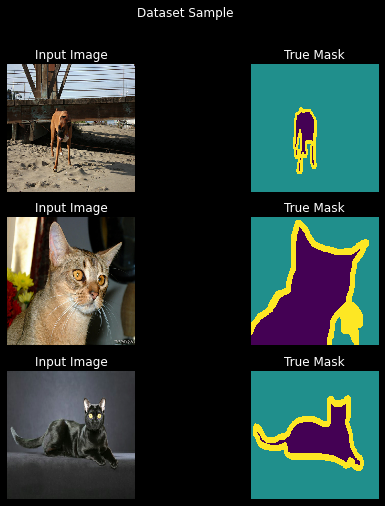

In [14]:
dataset_select = 'oxiiit'

if inColab:
    from google.colab import drive
    drive.mount('/content/drive')
    # enter the complete path for the colab notebook.
    cwd = '/content/drive/MyDrive/Colab Notebooks and Jamboards/Colab Notebooks/NNFL/New segmentation code'  
    if dataset_select == 'oxiiit':
        cwd1 = f"{cwd}/dataset_1"
    elif dataset_select == 'voc':
        cwd2 = f"{cwd}/dataset_2"
elif inKaggle:
    cwd_in = '/kaggle/input'
    cwd = '/kaggle/working'
    if dataset_select == 'oxiiit':
        cwd1 = f"{cwd_in}/oxiiit"
    elif dataset_select == 'voc':
        cwd2 = f"{cwd_in}/voc2012mod"
else:
    cwd = os.getcwd()
    if dataset_select == 'oxiiit':
        cwd1 = os.path.join(cwd, f"dataset_1")
    elif dataset_select == 'voc':
        cwd2 = os.path.join(cwd, f"dataset_2")

# Dataset parameters
if dataset_select == 'oxiiit':
    BATCH_SIZE = 10
    BUFFER_SIZE = 1000
    load_from_tfds = True
    img_dir = os.path.join(cwd1, f"JPEGImages")
    mask_dir = os.path.join(cwd1, f"SegmentationClass")
    train_txt_path = os.path.join(cwd1, f"DatasetInfo", f"trainval.txt")
    val_txt_path = os.path.join(cwd1, f"DatasetInfo", f"test.txt")
    input_shape = (128, 128, 3) # input_height, input_width, input_channels
    learn_r = 1e-3
    output_classes = 3
elif dataset_select == 'voc':
    BATCH_SIZE = 30
    BUFFER_SIZE = 1000
    load_from_tfds = False
    img_dir = os.path.join(cwd2, f"JPEGImages")
    mask_dir = os.path.join(cwd2, f"SegmentationClassFinal4")
    train_txt_path = os.path.join(cwd2, f"DatasetInfo", f"train3.txt")
    val_txt_path = os.path.join(cwd2, f"DatasetInfo", f"val.txt")
    input_shape = (128, 128, 3) # input_height, input_width, input_channels
    learn_r = 1e-3
    output_classes = 21

### M0. Regular UNet;  M1. PixelDCN;  M2. iPixelDCN;  M3. modified iPixelDCN;  M4. Deeplab
Instantiates all of the models mentioned in the title, with particular settings that have been selected from observing outcomes from multiple training sessions.

In [ ]:
def UNet_model(train_batches, validation_batches, input_shape, output_classes, 
               cwd, BATCH_SIZE, TRAIN_LENGTH, VAL_LENGTH, 
               VAL_SUBSPLITS, EPOCHS):

    dcl_type = 'ipixel'
    conv_option = 'sepconv2d'
    pool_option = 'conv'
    model_summary = False
    network_depth = 5
    filter_init = 2**6
    growth_rate = 2**4
    dropout = 0.2
    pyramid_layers = [1, 6, 12, 18]

    dense_layers = []
    for i in range(network_depth):
        dense_layers.append(2**(i+2))

    # Training parameters
    models = ["regular_UNet", "pixeldense", "deeplab", "deeplab_pre"]
    model_select = models[0]

    model = compile_and_train_model(TRAIN_LENGTH, VAL_LENGTH,
                                    train_batches, validation_batches, 
                                    BATCH_SIZE, EPOCHS, 
                                    VAL_SUBSPLITS, output_classes,
                                    input_shape, filter_init,
                                    network_depth, dcl_type, 
                                    model_summary, dense_layers,
                                    growth_rate, dropout,
                                    conv_option, pool_option,
                                    pyramid_layers, model_select,
                                    cwd, model_name='model_0',
                                    d_format='NHWC')
    return model


def PixelDenseNet(train_batches, validation_batches, input_shape, output_classes, 
                  cwd, BATCH_SIZE, TRAIN_LENGTH, VAL_LENGTH, 
                  VAL_SUBSPLITS, EPOCHS):

    dcl_type = 'pixel'
    conv_option = 'sepconv2d'
    pool_option = 'conv'
    model_summary = False
    network_depth = 5
    filter_init = 2**6
    growth_rate = 2**4
    dropout = 0.2
    pyramid_layers = [1, 6, 12, 18]

    dense_layers = []
    for i in range(network_depth):
        dense_layers.append(2**(i+2))

    # Training parameters
    models = ["regular_UNet", "pixeldense", "deeplab", "deeplab_pre"]
    model_select = models[1]

    model = compile_and_train_model(TRAIN_LENGTH, VAL_LENGTH,
                                    train_batches, validation_batches, 
                                    BATCH_SIZE, EPOCHS, 
                                    VAL_SUBSPLITS, output_classes,
                                    input_shape, filter_init,
                                    network_depth, dcl_type, 
                                    model_summary, dense_layers,
                                    growth_rate, dropout,
                                    conv_option, pool_option,
                                    pyramid_layers, model_select,
                                    cwd, model_name='model_1',
                                    d_format='NHWC')
    return model


def iPixelDenseNet(train_batches, validation_batches, input_shape, output_classes, 
                   cwd, BATCH_SIZE, TRAIN_LENGTH, VAL_LENGTH, 
                   VAL_SUBSPLITS, EPOCHS):

    dcl_type = 'ipixel'
    conv_option = 'sepconv2d'
    pool_option = 'conv'
    model_summary = False
    network_depth = 5
    filter_init = 2**6
    growth_rate = 2**4
    dropout = 0.2
    pyramid_layers = [1, 6, 12, 18]

    dense_layers = []
    for i in range(network_depth):
        dense_layers.append(2**(i+2))

    # Training parameters
    models = ["regular_UNet", "pixeldense", "deeplab", "deeplab_pre"]
    model_select = models[1]

    model = compile_and_train_model(TRAIN_LENGTH, VAL_LENGTH,
                                    train_batches, validation_batches, 
                                    BATCH_SIZE, EPOCHS, 
                                    VAL_SUBSPLITS, output_classes,
                                    input_shape, filter_init,
                                    network_depth, dcl_type, 
                                    model_summary, dense_layers,
                                    growth_rate, dropout,
                                    conv_option, pool_option,
                                    pyramid_layers, model_select,
                                    cwd, model_name='model_2',
                                    d_format='NHWC')
    return model


def modifiediPixelDenseNet(train_batches, validation_batches, input_shape, output_classes, 
                           cwd, BATCH_SIZE, TRAIN_LENGTH, VAL_LENGTH, 
                           VAL_SUBSPLITS, EPOCHS):

    dcl_type = 'modified ipixel'
    conv_option = 'sepconv2d'
    pool_option = 'conv'
    model_summary = False
    network_depth = 5
    filter_init = 2**6
    growth_rate = 2**4
    dropout = 0.2
    pyramid_layers = [1, 6, 12, 18]

    dense_layers = []
    for i in range(network_depth):
        dense_layers.append(2**(i+2))

    # Training parameters
    models = ["regular_UNet", "pixeldense", "deeplab", "deeplab_pre"]
    model_select = models[1]

    model = compile_and_train_model(TRAIN_LENGTH, VAL_LENGTH,
                                    train_batches, validation_batches, 
                                    BATCH_SIZE, EPOCHS, 
                                    VAL_SUBSPLITS, output_classes,
                                    input_shape, filter_init,
                                    network_depth, dcl_type, 
                                    model_summary, dense_layers,
                                    growth_rate, dropout,
                                    conv_option, pool_option,
                                    pyramid_layers, model_select,
                                    cwd, model_name='model_3', 
                                    d_format='NHWC')
    return model


def Deeplab(train_batches, validation_batches, input_shape, output_classes, 
            cwd, BATCH_SIZE, TRAIN_LENGTH, VAL_LENGTH, 
            VAL_SUBSPLITS, EPOCHS):

    dcl_type = 'modified ipixel'
    conv_option = 'sepconv2d'
    pool_option = 'conv'
    model_summary = False
    network_depth = 5
    filter_init = 2**6
    growth_rate = 2**4
    dropout = 0.2
    pyramid_layers = [1, 6, 12, 18]

    dense_layers = []
    for i in range(network_depth):
        dense_layers.append(2**(i+2))

    # Training parameters
    models = ["regular_UNet", "pixeldense", "deeplab", "deeplab_pre"]
    model_select = models[2]

    model = compile_and_train_model(TRAIN_LENGTH, VAL_LENGTH,
                                    train_batches, validation_batches, 
                                    BATCH_SIZE, EPOCHS, 
                                    VAL_SUBSPLITS, output_classes,
                                    input_shape, filter_init,
                                    network_depth, dcl_type, 
                                    model_summary, dense_layers,
                                    growth_rate, dropout,
                                    conv_option, pool_option,
                                    pyramid_layers, model_select,
                                    cwd, model_name='model_4',
                                    d_format='NHWC')
    return model

(train_batches,
validation_batches, 
TRAIN_LENGTH, 
VAL_LENGTH) = load_and_split_dataset(
                                    BATCH_SIZE, 
                                    BUFFER_SIZE, 
                                    load_from_tfds, 
                                    img_dir, 
                                    mask_dir, 
                                    train_txt_path, 
                                    val_txt_path, 
                                    input_shape[:-1]
                                    )
VAL_SUBSPLITS = 5
learn_r = 1e-3

samples = []
for images, masks in train_batches.take(3):
    samples.append(images[0])
    samples.append(masks[0])
display('Dataset Sample', 'no_models', samples, 3,
        cwd, mode=0)

### Training and Evaluation on Validation Data.
This modules trains a model and saves it or evaluates the validation dataset with a trained model, depending on what is the value assigned to the train variable, 

1/1 [==============================] - 0s 131ms/step


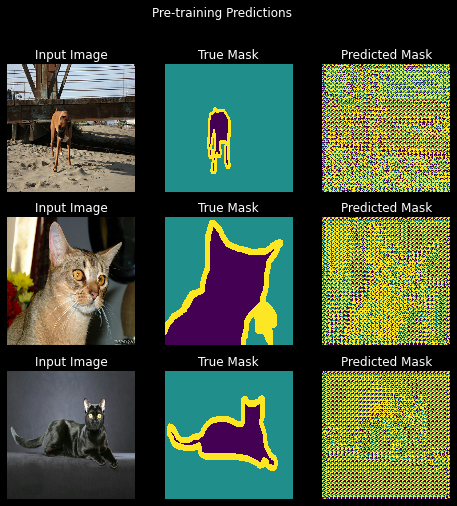


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


368/368 [==============================] - ETA: 0s - loss: 0.6317 - accuracy: 0.7437 - miou: 0.4679

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 133ms/step


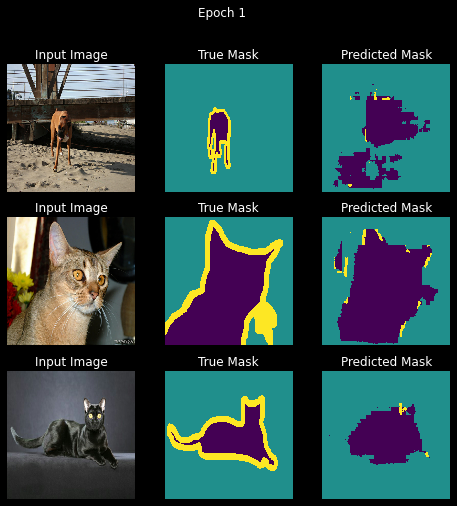


Sample Prediction after epoch 1

368/368 [==============================] - 189s 378ms/step - loss: 0.6317 - accuracy: 0.7437 - miou: 0.4679 - val_loss: 0.6687 - val_accuracy: 0.7231 - val_miou: 0.4290 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009095325760829623.
Epoch 2/10
368/368 [==============================] - ETA: 0s - loss: 0.4842 - accuracy: 0.8112 - miou: 0.5643

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 125ms/step


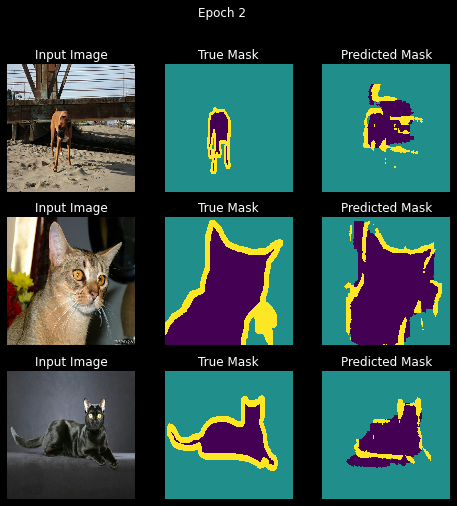


Sample Prediction after epoch 2

368/368 [==============================] - 132s 358ms/step - loss: 0.4842 - accuracy: 0.8112 - miou: 0.5643 - val_loss: 0.4841 - val_accuracy: 0.8168 - val_miou: 0.5961 - lr: 9.0953e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008180521460508585.
Epoch 3/10
364/368 [============================>.] - ETA: 1s - loss: 0.4104 - accuracy: 0.8412 - miou: 0.6206

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 135ms/step


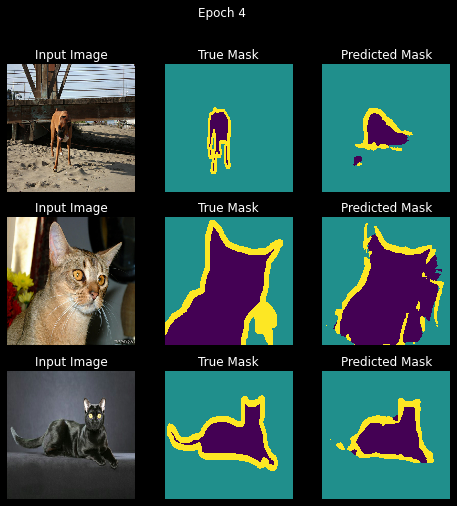


Sample Prediction after epoch 4

368/368 [==============================] - 136s 370ms/step - loss: 0.3610 - accuracy: 0.8619 - miou: 0.6568 - val_loss: 0.3708 - val_accuracy: 0.8631 - val_miou: 0.6723 - lr: 7.2542e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006314458674893553.
Epoch 5/10
356/368 [============================>.] - ETA: 4s - loss: 0.3298 - accuracy: 0.8739 - miou: 0.6781

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 125ms/step


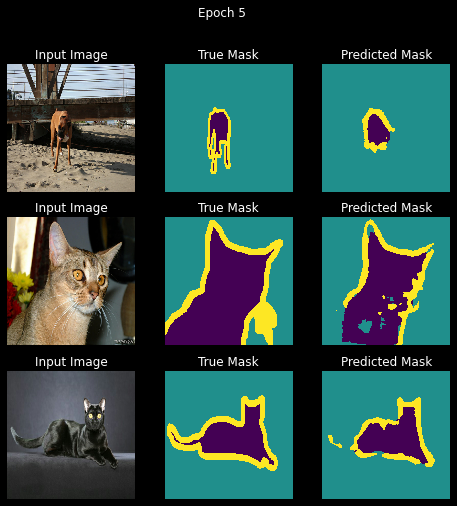


Sample Prediction after epoch 5

368/368 [==============================] - 131s 356ms/step - loss: 0.3295 - accuracy: 0.8740 - miou: 0.6786 - val_loss: 0.3385 - val_accuracy: 0.8704 - val_miou: 0.6834 - lr: 6.3145e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0005358867312681466.
Epoch 6/10
356/368 [============================>.] - ETA: 4s - loss: 0.2986 - accuracy: 0.8858 - miou: 0.6991

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 119ms/step


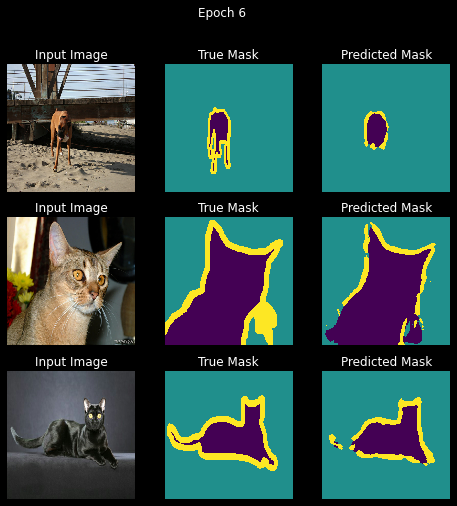


Sample Prediction after epoch 6

368/368 [==============================] - 131s 357ms/step - loss: 0.2991 - accuracy: 0.8856 - miou: 0.6990 - val_loss: 0.3159 - val_accuracy: 0.8808 - val_miou: 0.6898 - lr: 5.3589e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.00043838329055408696.
Epoch 7/10
356/368 [============================>.] - ETA: 4s - loss: 0.2678 - accuracy: 0.8974 - miou: 0.7200

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 137ms/step


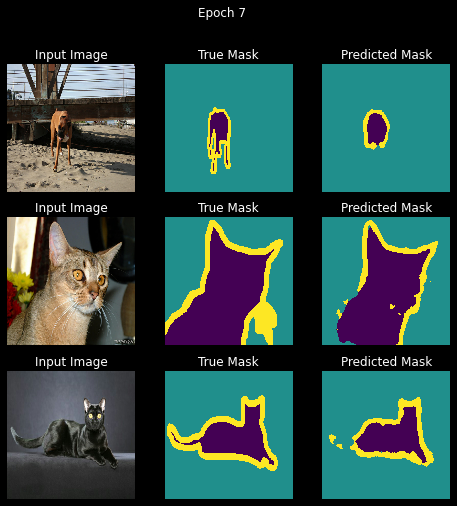


Sample Prediction after epoch 7

368/368 [==============================] - 132s 359ms/step - loss: 0.2680 - accuracy: 0.8972 - miou: 0.7197 - val_loss: 0.3012 - val_accuracy: 0.8862 - val_miou: 0.7043 - lr: 4.3838e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0003383834619016499.
Epoch 8/10
356/368 [============================>.] - ETA: 4s - loss: 0.2407 - accuracy: 0.9075 - miou: 0.7388

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 126ms/step


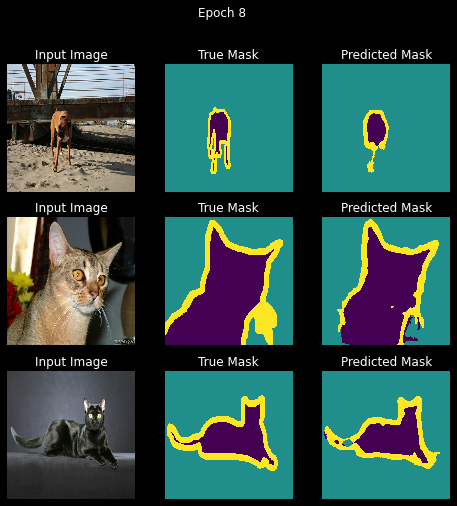


Sample Prediction after epoch 8

368/368 [==============================] - 131s 357ms/step - loss: 0.2405 - accuracy: 0.9075 - miou: 0.7389 - val_loss: 0.3065 - val_accuracy: 0.8869 - val_miou: 0.7144 - lr: 3.3838e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.00023492378861760376.
Epoch 9/10
356/368 [============================>.] - ETA: 4s - loss: 0.2201 - accuracy: 0.9144 - miou: 0.7530

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 141ms/step


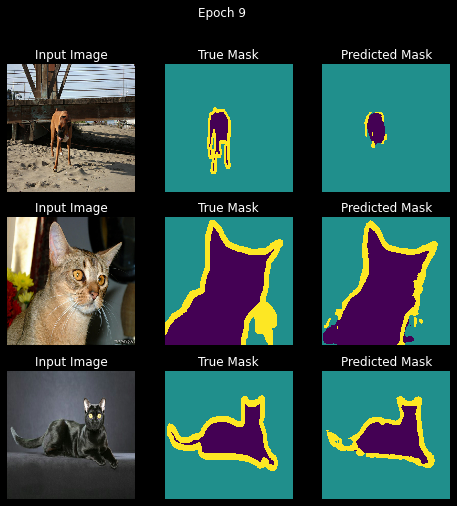


Sample Prediction after epoch 9

368/368 [==============================] - 136s 369ms/step - loss: 0.2201 - accuracy: 0.9145 - miou: 0.7531 - val_loss: 0.3078 - val_accuracy: 0.8856 - val_miou: 0.7014 - lr: 2.3492e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.00012589254117941672.
Epoch 10/10
356/368 [============================>.] - ETA: 4s - loss: 0.1979 - accuracy: 0.9224 - miou: 0.7688

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 123ms/step


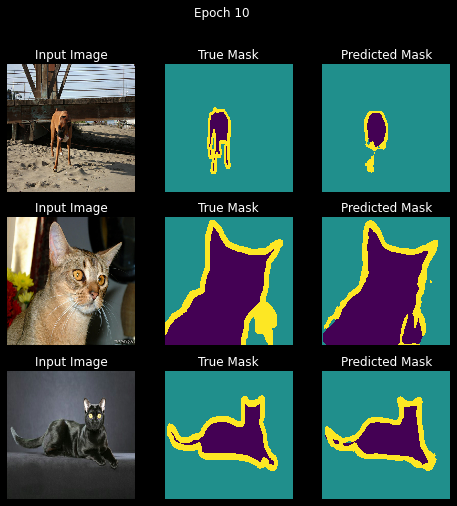


Sample Prediction after epoch 10

368/368 [==============================] - 131s 356ms/step - loss: 0.1977 - accuracy: 0.9224 - miou: 0.7690 - val_loss: 0.2891 - val_accuracy: 0.8959 - val_miou: 0.7284 - lr: 1.2589e-04


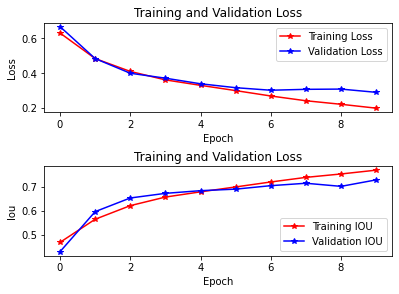

1/1 [==============================] - 0s 202ms/step


<Figure size 432x288 with 0 Axes>

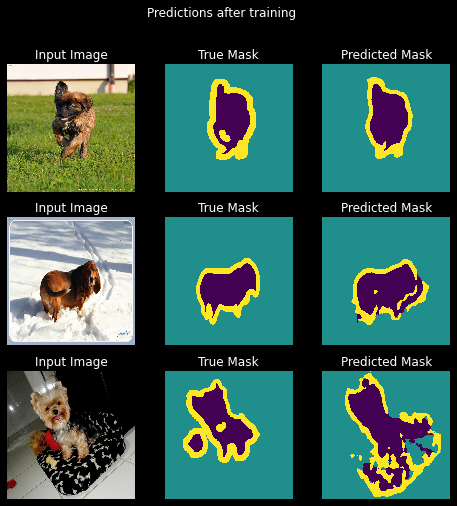

367/367 [==============================] - 31s 84ms/step - loss: 0.2827 - accuracy: 0.8965 - miou: 0.7284


In [25]:
def main_train(model_num, EPOCHS):
    if model_num == 0:
        model = UNet_model(train_batches, validation_batches, input_shape, output_classes, 
                            cwd, BATCH_SIZE, TRAIN_LENGTH, VAL_LENGTH, 
                            VAL_SUBSPLITS, EPOCHS)
    elif model_num == 1:
        model = PixelDenseNet(train_batches, validation_batches, input_shape, output_classes,
                                cwd, BATCH_SIZE, TRAIN_LENGTH, VAL_LENGTH, 
                                VAL_SUBSPLITS, EPOCHS)
    elif model_num == 2:
        model = iPixelDenseNet(train_batches, validation_batches, input_shape, output_classes, 
                                cwd, BATCH_SIZE, TRAIN_LENGTH, VAL_LENGTH, 
                                VAL_SUBSPLITS, EPOCHS)
    elif model_num == 3:
        model = modifiediPixelDenseNet(train_batches, validation_batches, input_shape, output_classes, 
                                        cwd, BATCH_SIZE, TRAIN_LENGTH, VAL_LENGTH, 
                                        VAL_SUBSPLITS, EPOCHS)
    else: # control model, to test.
        model = Deeplab(train_batches, validation_batches, input_shape, output_classes, 
                        cwd, BATCH_SIZE, TRAIN_LENGTH, VAL_LENGTH, 
                        VAL_SUBSPLITS, EPOCHS)
    model(cwd, learn_r, samples)


def main_eval(model_num):
    try:
        loaded_model = tf.keras.models.load_model(os.path.join(cwd, 
                                                            f'saved_model', 
                                                            f'model_{model_num}', 
                                                            f'saved_complete_model'), 
                                                  compile=False) 
                                                #, custom_objects={'mod_MeanIoU': mod_MeanIoU})
        miou = mod_MeanIoU(num_classes=output_classes, name='miou')
        opts = [optimizers.Adam(),
                optimizers.SGD(momentum=0.9, decay=5e-4, nesterov=False),
                optimizers.Adadelta()]
        loss_functions = [keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        SparseCategoricalFocalLoss(gamma=2, from_logits=False),
                        AsymmetricLoss(from_logits=False)]
        metrics_to_compile = ['accuracy', miou]          
        loaded_model.compile(optimizer=opts[0],
                            loss=loss_functions[0],
                            metrics=metrics_to_compile)
        loaded_model.evaluate(validation_batches)
        show_predictions('Predictions after training', f'model_{model_num}', samples, loaded_model, 
                        cwd, dataset=validation_batches, mode=3, num=3)
    except:
        print("Model doesn't exist. Train and save the model first and then use this option.")
        

train = True
ev = True
model_num = 4
if train:
    EPOCHS = 10
    main_train(model_num, EPOCHS)
elif ev:
    main_eval(model_num)

In [29]:
import shutil
OUTPUT_NAME = 'outputs'
DIRECTORY_TO_ZIP = '/kaggle/working'
shutil.make_archive(OUTPUT_NAME, 'zip', DIRECTORY_TO_ZIP)

'/kaggle/working/outputs.zip'

### Uploading to Tensorboard
Uploading the data to Tensorboard. (This section is not included in the python code because VS code has an extension that helps visualize tensorboard logs, and this Tensorboard doesn't work with Kaggle, therefore this part is only relevant for Colab use)

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "Segmentation on Oxford-IIIT Pets dataset" \
  --description "Training results from https://colab.research.google.com/drive/1tNoyaNEeSrbHPaUKVxwTEooHeCnVVL5P#scrollTo=BlF8wzgnWaY1" \
  --one_shot

## Clear memory


In [ ]:
!pip install numba

from numba import cuda 
device = cuda.get_current_device()
device.reset()

# Extras
Code used for modifying the PASCAL VOC dataset so that it can be pre processed appropriately for it to be put through the neural network.

In [ ]:
import numpy as np
import imageio
import cv2
import os
import time
from numba import jit, prange

from google.colab import drive
drive.mount('/content/drive')

@jit(nopython=True, nogil=True, parallel=True)
def img_mod_parallel(image):
    #if len(image) is not None:
    for j_num in prange(len(image)):
        #if len(image[j_num]) is not None:
        for k_num in prange(len(image[j_num])):
            if list(image[j_num][k_num]) == [0,0,0]:
                image[j_num][k_num] = 1
    return image

@jit(nopython=True, nogil=True)
def img_mod(image):
    for j_num, j in enumerate(image):
        for k_num, k in enumerate(j):
            if list(k) == [0,0,0]:
                    image[j_num, k_num] = 1
    return image

main_dir =  '/content/drive/MyDrive/Colab Notebooks and Jamboards/Colab Notebooks/NNFL/New segmentation code'
filenames = os.listdir(f"{main_dir}/dataset_2/SegmentationClassFinal3")
t0 = time.time()
images = [cv2.imread(f"{main_dir}/dataset_2/SegmentationClassFinal3/{elem}") for elem in filenames]

for index, (filename ,image) in enumerate(zip(filenames, images)):
    print(index, filename)
    # for j_num, j in enumerate(image):
    #     for k_num, k in enumerate(j):
    #         if list(k) == [0,0,0]:
    #                 image[j_num, k_num] = 1
    final_image = img_mod_parallel(image)
    imageio.imwrite(f"{main_dir}/dataset_2/SegmentationClassFinal3/{filename}", final_image.astype(np.uint8))

t1 = time.time()
print(f"total_time:{t1-t0}")